In [32]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [33]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [34]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current


,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,dt,dates,h_date,h_time
0,16.08,15.78,16.08,17.21,1013,1013,1003,78,-1.13,1716022800,2024-05-18 11:00:00,18/05/2024 11:00:00,11
1,16.97,16.60,16.97,18.76,1013,1013,1003,72,-1.79,1716033600,2024-05-18 14:00:00,18/05/2024 14:00:00,14
2,18.08,17.61,18.08,19.08,1012,1012,1002,64,-1.00,1716044400,2024-05-18 17:00:00,18/05/2024 17:00:00,17
3,17.27,16.98,17.27,17.27,1012,1012,1002,74,0.00,1716055200,2024-05-18 20:00:00,18/05/2024 20:00:00,20
4,14.07,13.86,14.07,14.07,1013,1013,1003,89,0.00,1716066000,2024-05-18 23:00:00,18/05/2024 23:00:00,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,15.26,15.01,15.26,15.26,1011,1011,1002,83,0.00,1716400800,2024-05-22 20:00:00,22/05/2024 20:00:00,20
36,12.18,11.86,12.18,12.18,1013,1013,1003,92,0.00,1716411600,2024-05-22 23:00:00,22/05/2024 23:00:00,23
37,11.19,10.85,11.19,11.19,1013,1013,1003,95,0.00,1716422400,2024-05-23 02:00:00,23/05/2024 02:00:00,02
38,9.99,8.71,9.99,9.99,1013,1013,1004,95,0.00,1716433200,2024-05-23 05:00:00,23/05/2024 05:00:00,05


In [35]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('18/05/2024 11:00:00', '23/05/2024 08:00:00')

<Axes: >

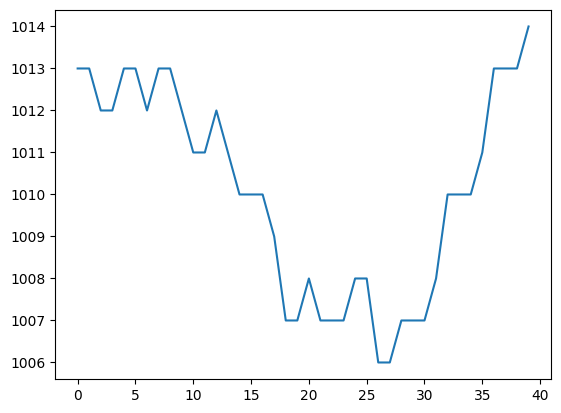

In [36]:
(current.pressure).plot()


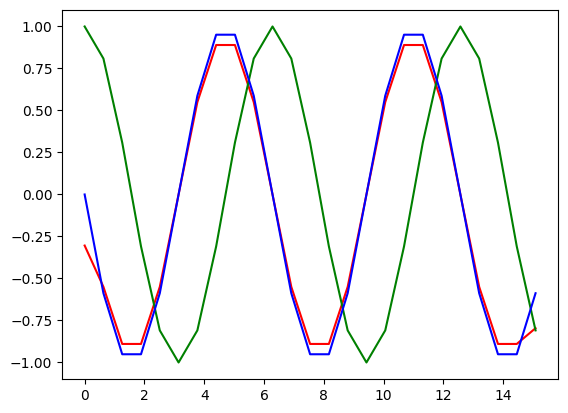

In [37]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

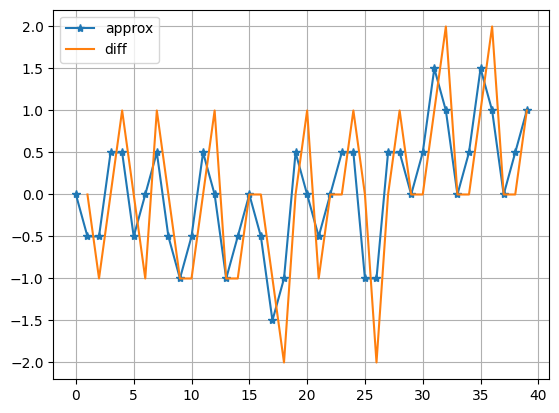

In [38]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


In [39]:
dy.diff()

0     NaN
1     0.0
2    -1.0
3     0.0
4     1.0
     ... 
35    1.0
36    2.0
37    0.0
38    0.0
39    1.0
Name: pressure, Length: 40, dtype: float64

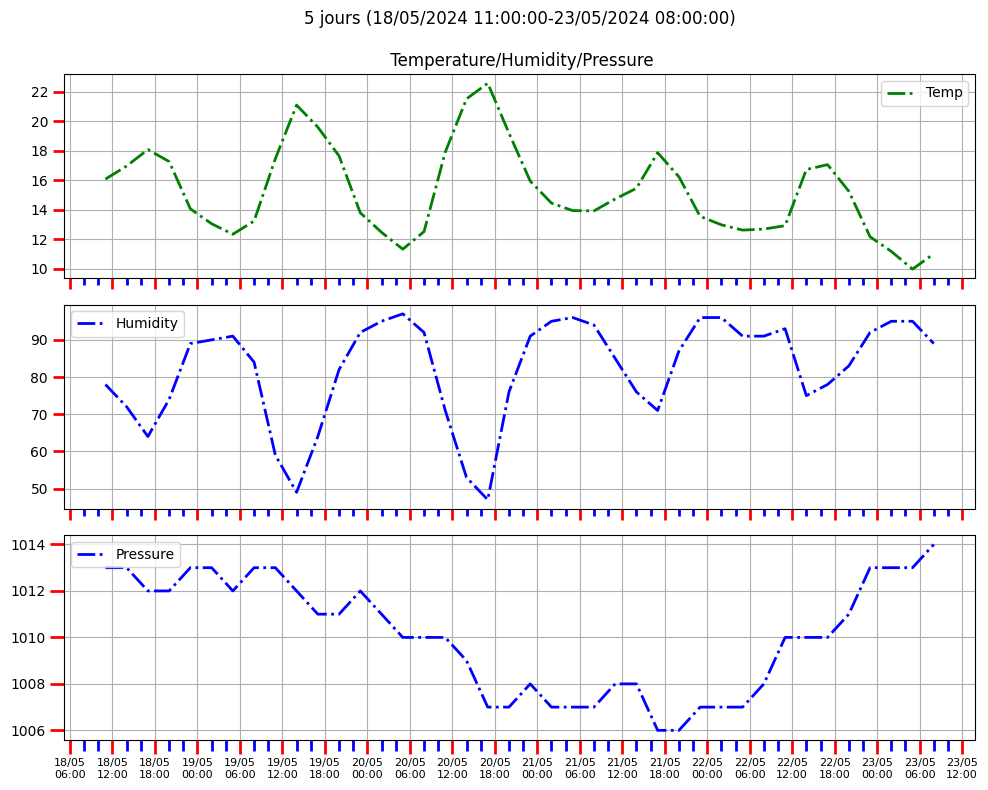

In [40]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

In [41]:
'''Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre
'''
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


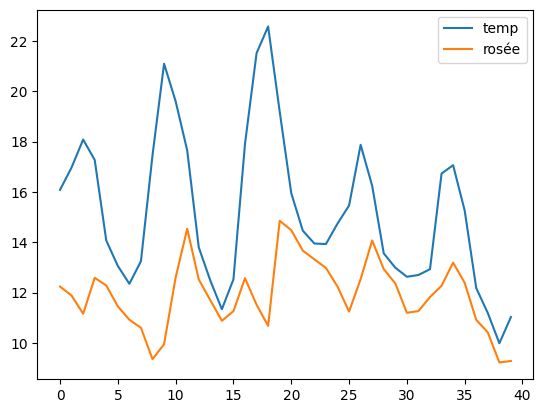

In [42]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='rosée')
plt.legend()


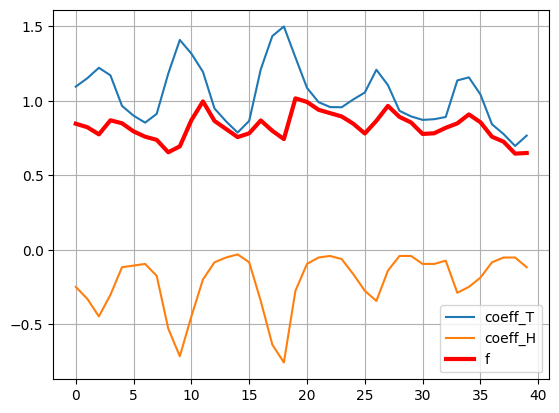

In [43]:
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha()
plt.plot(x,f,label='f',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

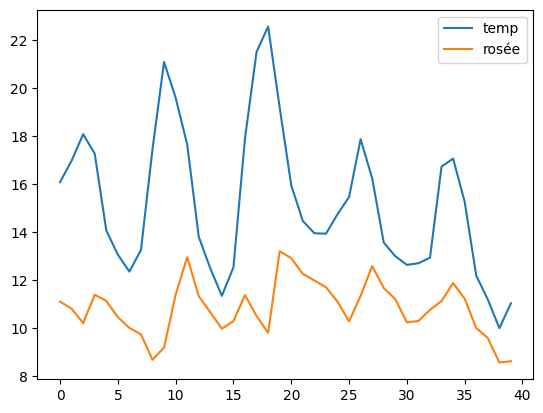

In [44]:
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a+f),label='rosée')
plt.legend()
b,a


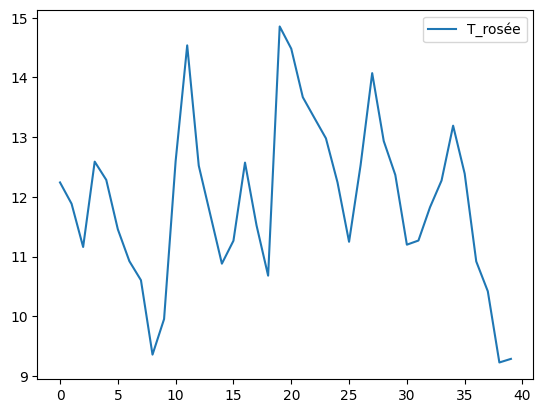

In [45]:
plt.plot(x,b*f/(a-f),label='T_rosée')
plt.legend()

In [46]:

f = y_temp+y_hum
f, alpha(y_temp,x_hum)


(0     0.845800
 1     0.822287
 2     0.774456
 3     0.868652
 4     0.848589
         ...   
 35    0.855496
 36    0.758417
 37    0.725159
 38    0.645252
 39    0.649309
 Length: 40, dtype: float64,
 0    -0.169323
 1    -0.245297
 2    -0.358048
 3    -0.216533
 4    -0.046697
         ...   
 35   -0.110966
 36   -0.022437
 37    0.004936
 38   -0.000834
 39   -0.061070
 Length: 40, dtype: float64)

In [47]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.248461
 1    -0.328504
 2    -0.446287
 3    -0.301105
 4    -0.116534
         ...   
 35   -0.186330
 36   -0.083382
 37   -0.051293
 38   -0.051293
 39   -0.116534
 Name: humidity, Length: 40, dtype: float64)

In [48]:
dewpoint(current.temp[0],current.humidity[0]/100)

(16.08, 12.240877057011637, 3.839122942988361)

In [49]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt

(0     16.08
 1     16.97
 2     18.08
 3     17.27
 4     14.07
       ...  
 35    15.26
 36    12.18
 37    11.19
 38     9.99
 39    11.03
 Name: temp, Length: 40, dtype: float64,
 0     12.240877
 1     11.883571
 2     11.159870
 3     12.589119
 4     12.283325
         ...    
 35    12.388519
 36    10.918135
 37    10.418376
 38     9.225788
 39     9.286062
 Length: 40, dtype: float64,
 0     3.839123
 1     5.086429
 2     6.920130
 3     4.680881
 4     1.786675
         ...   
 35    2.871481
 36    1.261865
 37    0.771624
 38    0.764212
 39    1.743938
 Length: 40, dtype: float64)

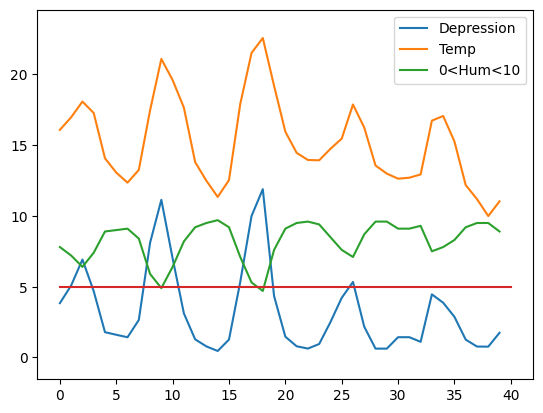

In [50]:
plt.plot(dewpt[2],label='Depression')
plt.plot(current.temp,label='Temp')
plt.plot(current.humidity/10,label='0<Hum<10')
plt.plot((0,40),(5,5))
plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
plt.legend()
plt.show()


In [51]:
current.temp.head(),current.h_time.head()

(0    16.08
 1    16.97
 2    18.08
 3    17.27
 4    14.07
 Name: temp, dtype: float64,
 0    11
 1    14
 2    17
 3    20
 4    23
 Name: h_time, dtype: object)

In [52]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,11,16.08,12.240877
1,14,16.97,11.883571
2,17,18.08,11.159870
3,20,17.27,12.589119
4,23,14.07,12.283325
...,...,...,...
35,20,15.26,12.388519
36,23,12.18,10.918135
37,02,11.19,10.418376
38,05,9.99,9.225788


In [53]:
current.dates

0    2024-05-18 11:00:00
1    2024-05-18 14:00:00
2    2024-05-18 17:00:00
3    2024-05-18 20:00:00
4    2024-05-18 23:00:00
             ...        
35   2024-05-22 20:00:00
36   2024-05-22 23:00:00
37   2024-05-23 02:00:00
38   2024-05-23 05:00:00
39   2024-05-23 08:00:00
Name: dates, Length: 40, dtype: datetime64[ns]

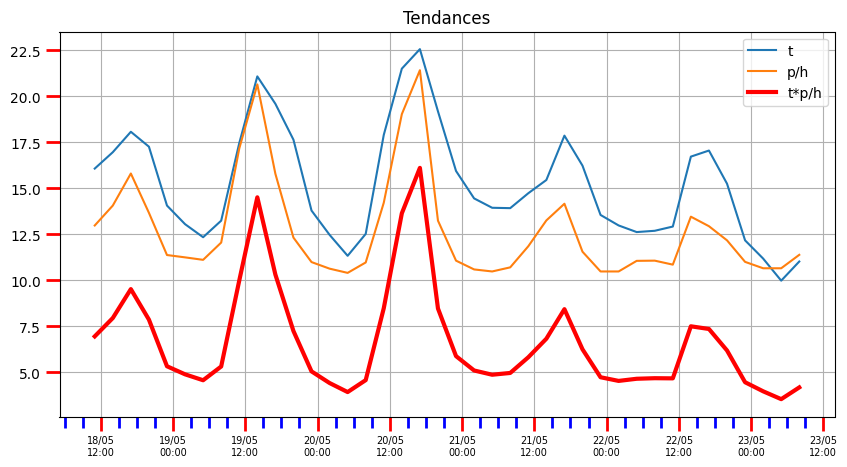

In [54]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

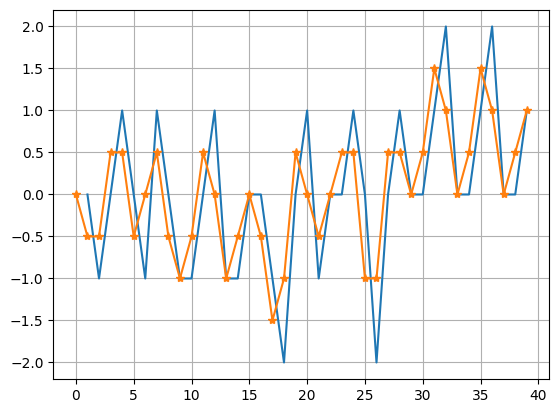

In [55]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [56]:
len(dy)

40

In [57]:
current.dates

0    2024-05-18 11:00:00
1    2024-05-18 14:00:00
2    2024-05-18 17:00:00
3    2024-05-18 20:00:00
4    2024-05-18 23:00:00
             ...        
35   2024-05-22 20:00:00
36   2024-05-22 23:00:00
37   2024-05-23 02:00:00
38   2024-05-23 05:00:00
39   2024-05-23 08:00:00
Name: dates, Length: 40, dtype: datetime64[ns]

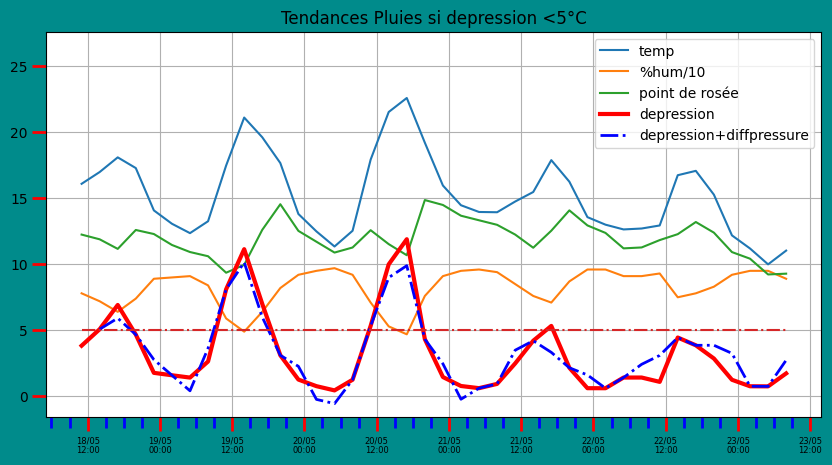

In [58]:
temp = current.temp  
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax = plt.subplots(facecolor='darkcyan')

# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=6)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, temp,label='temp')
plt.plot(current.dates, current.humidity/10,label='%hum/10')
plt.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
plt.plot(current.dates, depression,label="depression",lw=3,c='red')
plt.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
plt.plot((current.dates[0],current.dates[39]),(5,5),'-.')

plt.ylim(min(depression)-2,max(current.temp)+5)
plt.legend()
plt.title('Tendances Pluies si depression <5°C')
plt.grid()


In [59]:
datetime.now().strftime('%d/%m/%Y %H:%M:%S')

'18/05/2024 09:31:45'

In [60]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,18/05/2024 11:00:00,16.08,3.839123,pluie
1,18/05/2024 14:00:00,16.97,5.086429,beau temps
2,18/05/2024 17:00:00,18.08,6.920130,beau temps
3,18/05/2024 20:00:00,17.27,4.680881,pluie
4,18/05/2024 23:00:00,14.07,1.786675,pluie
5,19/05/2024 02:00:00,13.06,1.603566,pluie
6,19/05/2024 05:00:00,12.35,1.428254,pluie
7,19/05/2024 08:00:00,13.25,2.646542,pluie
8,19/05/2024 11:00:00,17.46,8.102533,beau temps
9,19/05/2024 14:00:00,21.09,11.137097,beau temps


In [61]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,20/05/2024 23:00:00,15.95,1.469554,pluie
21,21/05/2024 02:00:00,14.46,0.792000,pluie
22,21/05/2024 05:00:00,13.95,0.628176,pluie
23,21/05/2024 08:00:00,13.93,0.950774,pluie
24,21/05/2024 11:00:00,14.74,2.497928,pluie
25,21/05/2024 14:00:00,15.46,4.213300,pluie
26,21/05/2024 17:00:00,17.87,5.335605,beau temps
27,21/05/2024 20:00:00,16.24,2.168943,pluie
28,21/05/2024 23:00:00,13.56,0.626233,pluie
29,22/05/2024 02:00:00,12.99,0.623398,pluie


In [62]:
current.h_date

0     18/05/2024 11:00:00
1     18/05/2024 14:00:00
2     18/05/2024 17:00:00
3     18/05/2024 20:00:00
4     18/05/2024 23:00:00
             ...         
35    22/05/2024 20:00:00
36    22/05/2024 23:00:00
37    23/05/2024 02:00:00
38    23/05/2024 05:00:00
39    23/05/2024 08:00:00
Name: h_date, Length: 40, dtype: object